In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math
import scipy.io
import mat4py
from scipy.ndimage import gaussian_filter

In [ ]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))



In [247]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                   'cursor trajectory': np.array(cursor_trajectory, dtype = object)
})

In [160]:
df.to_csv('all_trajectories.csv')

In [ ]:
# df_list = []
# for file in os.listdir('data/'):
#     temp_df = pd.read_csv('data/'+file)
#     temp_df['p_id'] = int(file[:3])
#     df_list.append(temp_df)
# df = pd.concat(df_list).reset_index().drop('index', axis = 1)

In [219]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c

  # cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
  # angle = np.arccos(cosine_angle)
  # signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])

  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(np.abs(v1), np.abs(v2))
    ab_magnitudes = np.linalg.norm(np.abs(v1))
    ac_magnitudes = np.linalg.norm(np.abs(v2))
  # # print(dot_products.shape)
  # # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))

  return np.nanmean(angles)

In [220]:
def comp_avg_ang_error(traj):
    # try:
    # print(traj)

    end_point = traj[-1]
    curr_point = np.array(traj[:-1])
    next_point = np.array(traj[1:])
    
    angles = find_angles(curr_point, end_point, next_point)
    return angles
    # except:
    #     return np.NaN

In [162]:
def comp_init_ang_error(traj, proportion=0.1):
    cutoff_dist = proportion*np.sqrt(0.3**2 + 0.3**2)

    try:
        for cutoff_point in traj:
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = cutoff_point - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        return np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [241]:
def angular_dist(b, a, c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])


    return angle#, signed_angle

def calc_angular_error(traj):    
    init_error = np.zeros(64)
    mean_error = np.zeros(64)
    for j in range(64):
        traj_ang_errors = list()
        trajx, trajy = traj['x'][0][j][0].astype(float), traj['y'][0][j][0].astype(float)
        # print(trajx)
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]


        for i in range(len(trajx) - 1):
            ang_dist = angular_dist(np.array([trajx[i], trajy[i]]), np.array([trajx[i+1], trajy[i+1]]), np.array([trajx[-1], trajy[-1]]))
            traj_ang_errors.append(ang_dist)
        
        # init_error[j] = np.nanmean(traj_ang_errors[:np.argmax(velocity[j])])
        mean_error[j] = np.nanmean(traj_ang_errors)
    return mean_error

In [242]:
mean_error = np.zeros((60, 12, 64))

for data in range(1000, 1060):
    print(data)
    for block in range(12):        
        traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
        #init_error[data-1000][block], online_error[data-1000][block], max_vel_error[data-1000][block], signed_angles_var[data-1000][block], max_error[data-1000][block], mean_error[data-1000][block], ide[data-1000][block] = calc_angular_error(traj)
        mean_error[data-1000][block] = calc_angular_error(traj)

1000


C:\Users\tejas\AppData\Local\Temp\ipykernel_7500\3572372329.py:5: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
C:\Users\tejas\AppData\Local\Temp\ipykernel_7500\3572372329.py:4: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
C:\Users\tejas\AppData\Local\Temp\ipykernel_7500\3572372329.py:27: RuntimeWarning: Mean of empty slice
  mean_error[j] = np.nanmean(traj_ang_errors)


1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059


In [221]:
# df_relearn = pd.read_csv('all_trajectories.csv')
errors = []
for traj in df['cursor trajectory']:
    # print(traj)
    errors.append(comp_avg_ang_error(traj))


C:\Users\tejas\AppData\Local\Temp\ipykernel_7500\1002950747.py:18: RuntimeWarning: invalid value encountered in arccos
  angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))
C:\Users\tejas\AppData\Local\Temp\ipykernel_7500\1002950747.py:18: RuntimeWarning: invalid value encountered in double_scalars
  angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))
C:\Users\tejas\AppData\Local\Temp\ipykernel_7500\1002950747.py:20: RuntimeWarning: Mean of empty slice
  return np.nanmean(angles)


In [248]:
df['avg errors'] = np.ravel(errors)

# df.loc[df['p_id']%2 == 1, 'Emphasis'] = 'Accuracy'
# df.loc[df['p_id']%2 == 0, 'Emphasis'] = 'Speed'

# df.loc[df['p_id']%4 == 0, 'Rotation'] = 'Sudden'
# df.loc[df['p_id']%4 == 1, 'Rotation'] = 'Sudden'
# df.loc[df['p_id']%4 == 2, 'Rotation'] = 'Gradual'
# df.loc[df['p_id']%4 == 3, 'Rotation'] = 'Gradual'
df['avg errors degrees'] = df['avg errors']#*180/np.pi


In [250]:
smoothed = []
for participant in df.p_id.unique():
    for block in range(12):
        smoothed.append(gaussian_filter(df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'], sigma=2))

smoothed = np.ravel(smoothed)

df['smoothed avg error'] = smoothed
df['smoothed avg error degrees'] = df['smoothed avg error']*180/np.pi

In [245]:
df

,p_id,block no,trial no,cursor trajectory,avg errors,Emphasis,Rotation,avg errors degrees,smoothed avg error,smoothed avg error degrees
0,0,0,0,"[[0, 0], [30, -31], [43, -43], [53, -52], [62,...",0.087757,Speed,Sudden,0.087757,0.193450,11.083877
1,0,0,1,"[[0, 0], [-12, 14], [-26, 30], [-38, 43], [-56...",0.109257,Speed,Sudden,0.109257,0.248827,14.256715
2,0,0,2,"[[0, 0], [31, -25], [63, -50], [84, -65], [105...",0.233995,Speed,Sudden,0.233995,0.337547,19.340042
3,0,0,3,"[[0, 0], [-22, -16], [-35, -26], [-47, -34], [...",0.304085,Speed,Sudden,0.304085,0.415149,23.786260
4,0,0,4,"[[0, 0], [12, 7], [28, 17], [39, 24], [49, 31]...",1.568891,Speed,Sudden,1.568891,0.434931,24.919720
...,...,...,...,...,...,...,...,...,...,...
46075,59,11,763,"[[0, 0], [11, 32], [11, 32], [12, 34], [12, 35...",1.569352,Accuracy,Gradual,1.569352,0.593690,34.015951
46076,59,11,764,"[[0, 0], [11, -3], [12, -3], [14, -4], [16, -4...",0.283860,Accuracy,Gradual,0.283860,0.536271,30.726045
46077,59,11,765,"[[0, 0], [0, 0], [0, -1], [0, -2], [0, -3], [0...",0.303693,Accuracy,Gradual,0.303693,0.454323,26.030763
46078,59,11,766,"[[0, 0], [-1, -3], [-2, -4], [-2, -6], [-3, -7...",0.297377,Accuracy,Gradual,0.297377,0.380082,21.777115


In [251]:
df

,p_id,Trial,Block,Rotation,Emphasis,cursor trajectory,avg errors,avg errors degrees,smoothed avg error,smoothed avg error degrees
0,0,0,0,Sudden,Speed,"[[0, 0], [30, -31], [43, -43], [53, -52], [62,...",0.087757,0.087757,0.193450,11.083877
1,0,1,0,Sudden,Speed,"[[0, 0], [-12, 14], [-26, 30], [-38, 43], [-56...",0.109257,0.109257,0.248827,14.256715
2,0,2,0,Sudden,Speed,"[[0, 0], [31, -25], [63, -50], [84, -65], [105...",0.233995,0.233995,0.337547,19.340042
3,0,3,0,Sudden,Speed,"[[0, 0], [-22, -16], [-35, -26], [-47, -34], [...",0.304085,0.304085,0.415149,23.786260
4,0,4,0,Sudden,Speed,"[[0, 0], [12, 7], [28, 17], [39, 24], [49, 31]...",1.568891,1.568891,0.434931,24.919720
...,...,...,...,...,...,...,...,...,...,...
46075,59,763,11,Gradual,Accuracy,"[[0, 0], [11, 32], [11, 32], [12, 34], [12, 35...",1.569352,1.569352,0.593690,34.015951
46076,59,764,11,Gradual,Accuracy,"[[0, 0], [11, -3], [12, -3], [14, -4], [16, -4...",0.283860,0.283860,0.536271,30.726045
46077,59,765,11,Gradual,Accuracy,"[[0, 0], [0, 0], [0, -1], [0, -2], [0, -3], [0...",0.303693,0.303693,0.454323,26.030763
46078,59,766,11,Gradual,Accuracy,"[[0, 0], [-1, -3], [-2, -4], [-2, -6], [-3, -7...",0.297377,0.297377,0.380082,21.777115


In [ ]:
# df['avg errors smooth'] = 
gaussian_filter(avg[participant][block], sigma = 2)


In [253]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'smoothed avg error', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')

# draw lines:
# for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*8, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*9, ymax=100, ymin = -100, color = 'black', linestyles = '--')

#     ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

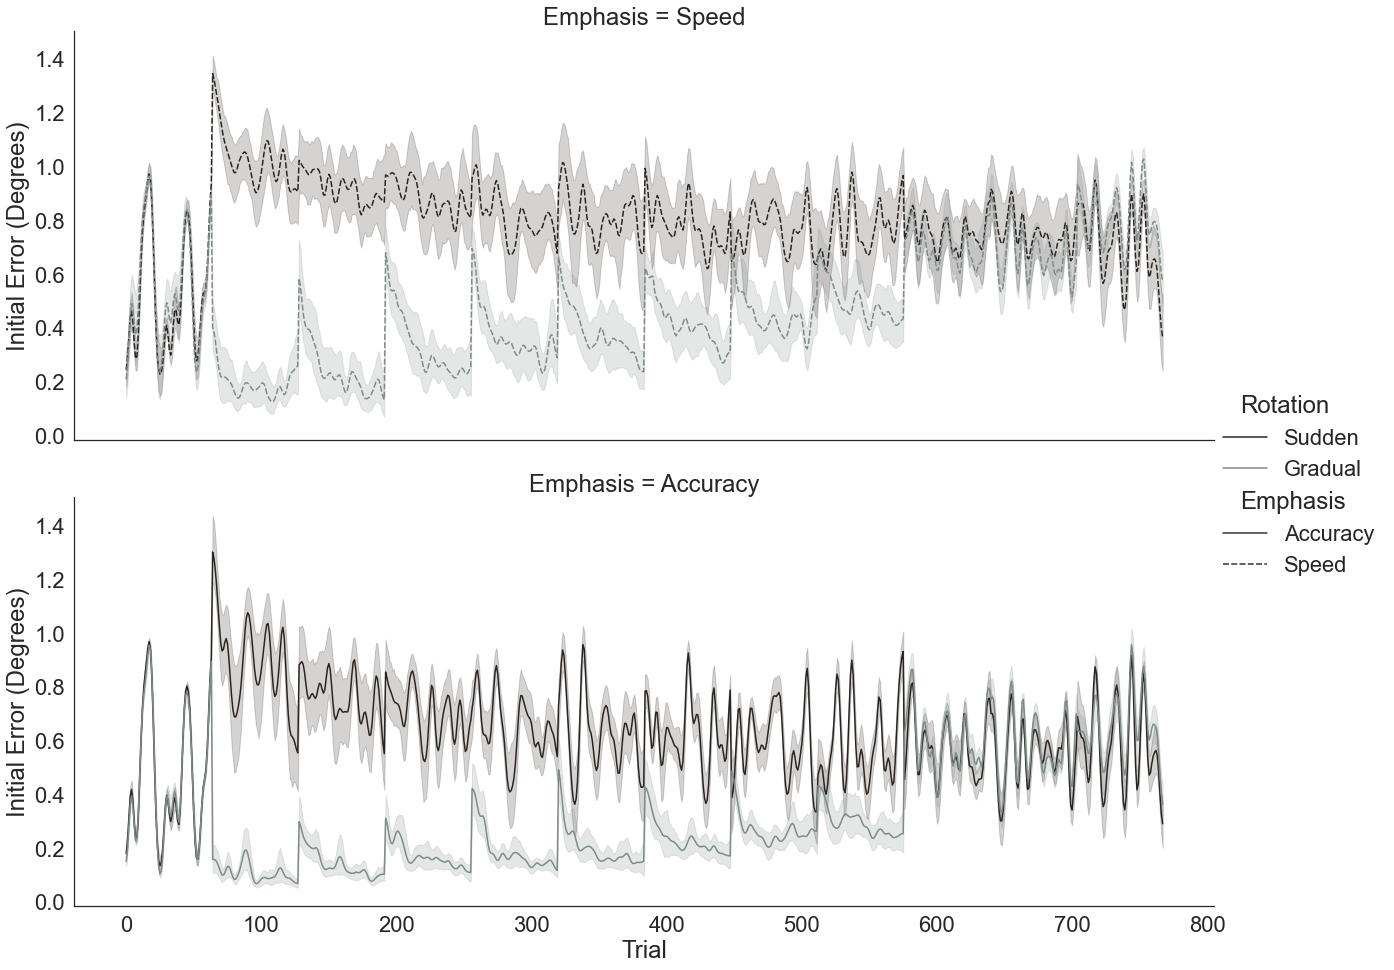

In [205]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial no', y = 'smoothed avg error', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')

# draw lines:
# for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*8, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*9, ymax=100, ymin = -100, color = 'black', linestyles = '--')

#     ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

In [ ]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial no', y = 'avg errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_allphases, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Curvature Error (Radians)')

# draw lines:
for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
#     ax.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

In [ ]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial no', y = 'init errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_allphases, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Aim Error (Radians)')

# draw lines:
for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
#     ax.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

In [ ]:
g = sns.catplot(x = 'Emphasis', y = 'init errors', hue = 'Rotation',   
                 hue_order=['Sudden', 'Gradual'],
            data = df_allphases.loc[df_allphases['phase'] == 'Relearning'], 
            kind = 'bar', capsize = 0.3)
plt.title('Relearning Phase')

In [ ]:
df_allphases[['p_id', 'Rotation', 'Emphasis', 'phase', 'trial no', 'block no', 'avg errors', 'init errors']].to_csv('df_allphases.csv', index = False)

In [ ]:
df_allphases = pd.read_csv('df_allphases.csv')

In [ ]:
df_allphases_blockwise = pd.read_csv('df_allphases_blockwise.csv')

In [ ]:
sns.catplot(y = 'initerrors_mean', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['phase'] == 'Relearning'))], 
            kind = 'bar', capsize = 0.2)

In [ ]:
df_allphases_blockwise['difference'] = df_allphases_blockwise['initerrors_mean'].diff(periods= 2)

In [ ]:
g = sns.catplot(y = 'difference', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['block no'] == 8))], 
            kind = 'bar', capsize = 0.2)
g.set_ylabels('Error Difference \n Relearning - Learning')


# First three aiming plots

In [ ]:
def clean_data_aim(df):
    # Drop columns: 'repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN' and 281 other columns
    df = df.drop(columns=['repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN', 'repeat_instructions.thisN', 'repeat_instructions.thisIndex', 'accuracy_instructions.thisRepN', 'accuracy_instructions.thisTrialN', 'accuracy_instructions.thisN', 'accuracy_instructions.thisIndex', 'speed_instructions.thisRepN', 'speed_instructions.thisTrialN', 'speed_instructions.thisN', 'speed_instructions.thisIndex', 'baseline_trials.thisRepN', 'baseline_trials.thisTrialN', 'baseline_trials.thisN', 'baseline_trials.thisIndex', 'rotated_blocks.thisRepN', 'rotated_blocks.thisTrialN', 'rotated_blocks.thisN', 'rotated_blocks.thisIndex', 'rotated_trials.thisRepN', 'rotated_trials.thisTrialN', 'rotated_trials.thisN', 'rotated_trials.thisIndex', 'unlearning_trials.thisTrialN', 'unlearning_trials.thisN', 'unlearning_trials.thisIndex', 'relearning_blocks.thisRepN', 'relearning_blocks.thisTrialN', 'relearning_blocks.thisN', 'relearning_blocks.thisIndex', 'relearning_trials.thisRepN', 'relearning_trials.thisTrialN', 'relearning_trials.thisN', 'relearning_trials.thisIndex', 'instr_adv_mouse_0.started', 'instr_adv_text_0.started', 'instr_adv_mouse_0.x', 'instr_adv_mouse_0.y', 'instr_adv_mouse_0.leftButton', 'instr_adv_mouse_0.midButton', 'instr_adv_mouse_0.rightButton', 'instr_adv_mouse_0.time', 'consent0.started', 'consent_text0.started', 'consent0_keyresp.started', 'consent0_keyresp.keys', 'consent0_keyresp.rt', 'consent_text1.started', 'consent1.started', 'consent1_keyresp.started', 'consent1_keyresp.keys', 'consent1_keyresp.rt', 'consent2.started', 'consent_text2.started', 'consent2_keyresp.started', 'consent2_keyresp.keys', 'consent2_keyresp.rt', 'consent_text3.started', 'consent3_keyresp.started', 'consent3.started', 'consent3_keyresp.keys', 'consent3_keyresp.rt', 'consent_text4.started', 'consent4_keyresp.started', 'consent4.started', 'consent4_keyresp.keys', 'consent4_keyresp.rt', 'agree.started', 'disagree.started', 'consent5.started', 'agree.numClicks', 'agree.timesOn', 'agree.timesOff', 'disagree.numClicks', 'disagree.timesOn', 'disagree.timesOff', 'age.started', 'respAge.started', 'gender.started', 'genderResp2.started', 'nextButton.started', 'mouse.started', 'respAge.response', 'respAge.rt', 'genderResp2.text', 'mouse.x', 'mouse.y', 'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'mouse.clicked_name', 'instr_adv_mouse_05.started', 'instr_adv_text_05.started', 'instr_adv_mouse_05.x', 'instr_adv_mouse_05.y', 'instr_adv_mouse_05.leftButton', 'instr_adv_mouse_05.midButton', 'instr_adv_mouse_05.rightButton', 'instr_adv_mouse_05.time', 'instr_adv_text_1.started', 'instr_adv_mouse_1.started', 'instr_adv_mouse_1.x', 'instr_adv_mouse_1.y', 'instr_adv_mouse_1.leftButton', 'instr_adv_mouse_1.midButton', 'instr_adv_mouse_1.rightButton', 'instr_adv_mouse_1.time', 'instr_adv_text_2.started', 'instr_adv_mouse_2.started', 'instr_adv_mouse_2.x', 'instr_adv_mouse_2.y', 'instr_adv_mouse_2.leftButton', 'instr_adv_mouse_2.midButton', 'instr_adv_mouse_2.rightButton', 'instr_adv_mouse_2.time', 'instr_acc_adv_text_3.started', 'instr_adv_mouse_3_acc.started', 'instr_adv_mouse_3_acc.x', 'instr_adv_mouse_3_acc.y', 'instr_adv_mouse_3_acc.leftButton', 'instr_adv_mouse_3_acc.midButton', 'instr_adv_mouse_3_acc.rightButton', 'instr_adv_mouse_3_acc.time', 'repeat_instructions_text.started', 'repeat_instr_adv.started', 'repeat_instr_repeat.started', 'repeat_instr_adv.x', 'repeat_instr_adv.y', 'repeat_instr_adv.leftButton', 'repeat_instr_adv.midButton', 'repeat_instr_adv.rightButton', 'repeat_instr_adv.time', 'repeat_instr_repeat.keys', 'text_countdown_2.started', 'cursor.started', 'cursor.stopped', 'target_baseline.started', 'mouse_baseline.started', 'cursor_baseline.started', 'target_baseline.stopped', 'mouse_baseline.stopped', 'cursor_baseline.stopped', 'mouse_baseline.x', 'mouse_baseline.y', 'mouse_baseline.leftButton', 'mouse_baseline.midButton', 'mouse_baseline.rightButton', 'mouse_baseline.time', 'mouse_baseline.clicked_name', 'break_text.started', 'break_mouse.started', 'improve_text.started', 'break_mouse.x', 'break_mouse.y', 'break_mouse.leftButton', 'break_mouse.midButton', 'break_mouse.rightButton', 'break_mouse.time', 'target_rotated.started', 'mouse_rotated.started', 'cursor_rotated.started', 'mouse_rotated.x', 'mouse_rotated.y', 'mouse_rotated.leftButton', 'mouse_rotated.midButton', 'mouse_rotated.rightButton', 'mouse_rotated.time', 'instr_adv_text_4.started', 'instr_adv_mouse_4.started', 'instr_adv_mouse_4.x', 'instr_adv_mouse_4.y', 'instr_adv_mouse_4.leftButton', 'instr_adv_mouse_4.midButton', 'instr_adv_mouse_4.rightButton', 'instr_adv_mouse_4.time', 'instr_adv_text_5.started', 'instr_adv_mouse_5.started', 'instr_adv_mouse_5.x', 'instr_adv_mouse_5.y', 'instr_adv_mouse_5.leftButton', 'instr_adv_mouse_5.midButton', 'instr_adv_mouse_5.rightButton', 'instr_adv_mouse_5.time', 'instr_adv_text_55.started', 'instr_adv_mouse_55.started', 'instr_adv_mouse_55.x', 'instr_adv_mouse_55.y', 'instr_adv_mouse_55.leftButton', 'instr_adv_mouse_55.midButton', 'instr_adv_mouse_55.rightButton', 'instr_adv_mouse_55.time', 'phase_cntdown.started', 'target_aiming.started', 'aim_typing_instruction.started', 'end_routine_instruction.started', 'aim_cursor.started', 'aim_report_end.started', 'aim_report_end.keys', 'aim_report_end.rt', 'target_swiping.started', 'swipe_cursor.started', 'aim_swipe_mouse.started', 'swiping_trial_instuctions.started', 'aim_swipe_mouse.leftButton', 'aim_swipe_mouse.midButton', 'aim_swipe_mouse.rightButton', 'aim_swipe_mouse.time', 'text.started', 'text.stopped', 'instr_adv_text_6.started', 'instr_adv_mouse_6.started', 'instr_adv_mouse_6.x', 'instr_adv_mouse_6.y', 'instr_adv_mouse_6.leftButton', 'instr_adv_mouse_6.midButton', 'instr_adv_mouse_6.rightButton', 'instr_adv_mouse_6.time', 'target_unlearning.started', 'mouse_unlearning.started', 'cursor_unlearning.started', 'mouse_unlearning.x', 'mouse_unlearning.y', 'mouse_unlearning.leftButton', 'mouse_unlearning.midButton', 'mouse_unlearning.rightButton', 'mouse_unlearning.time', 'no_score_break_text.started', 'no_score_break_mouse.started', 'no_score_break_mouse.x', 'no_score_break_mouse.y', 'no_score_break_mouse.leftButton', 'no_score_break_mouse.midButton', 'no_score_break_mouse.rightButton', 'no_score_break_mouse.time', 'study_done.started', 'study_done_mouse.started', 'thoughts_on_study.started', 'study_done_adv.started', 'study_done_mouse.x', 'study_done_mouse.y', 'study_done_mouse.leftButton', 'study_done_mouse.midButton', 'study_done_mouse.rightButton', 'study_done_mouse.time', 'thoughts_on_study.text', 'pre_debrief_text.started', 'pre_debrief_mouse.started', 'pre_debrief_mouse.x', 'pre_debrief_mouse.y', 'pre_debrief_mouse.leftButton', 'pre_debrief_mouse.midButton', 'pre_debrief_mouse.rightButton', 'pre_debrief_mouse.time', 'debrief_text.started', 'debrief_mouse.started', 'debrief_mouse.x', 'debrief_mouse.y', 'debrief_mouse.leftButton', 'debrief_mouse.midButton', 'debrief_mouse.rightButton', 'debrief_mouse.time', 'text_countdown.started', 'participant', 'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 280', 'instr_spd_adv_text_3.started', 'instr_adv_mouse_3_spd.started', 'instr_adv_mouse_3_spd.x', 'instr_adv_mouse_3_spd.y', 'instr_adv_mouse_3_spd.leftButton', 'instr_adv_mouse_3_spd.midButton', 'instr_adv_mouse_3_spd.rightButton', 'instr_adv_mouse_3_spd.time', 'phase_cntdown.stopped', 'Unnamed: 281', 'repeat_instr_repeat.rt', 'Unnamed: 282', 'unlearning_trials.thisRepN', 'aim_report_text.started'])
    # Filter rows based on column: 'aim_swipe_mouse.x'
    df = df[df['aim_swipe_mouse.x'].notna()]
    # Filter rows based on column: 'aim report'
    df = df[df['aim report'].notna()]
    # Drop column: 'aim_report_text.text'
    # df = df.drop(columns=['aim_report_text.text'])
    # Drop column: 'cursor trajectory'
    df = df.drop(columns=['cursor trajectory'])
    return df

df_aim = clean_data_aim(df.copy()).reset_index().drop('index', axis = 1)
# df_aim.head()

In [ ]:
df_aim['aim report'] = df_aim['aim report']*4
df_aim['trial'] = np.tile(np.arange(16), 62)
df_aim.loc[df_aim['p_id']%2 == 0, 'Rotation'] = 'Sudden'
df_aim.loc[df_aim['p_id']%2 == 1, 'Rotation'] = 'Gradual'

df_aim.loc[df_aim['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 2, 'Emphasis'] = 'Speed'
df_aim.loc[df_aim['p_id']%4 == 3, 'Emphasis'] = 'Speed'

df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 45
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 135
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 225
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 315

df_aim['optimal report'] = df_aim['target angle'] - 60
df_aim.loc[df_aim['optimal report'] < 0, 'optimal report'] = 360-15
df_aim['optimal report - report'] = df_aim['optimal report'] - df_aim['aim report']

df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report'] = 360 - df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report']
df_aim.loc[df_aim['optimal report - report'] < -180, 'optimal report - report'] = -360 - df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report']



In [ ]:
def find_aim_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  dotprod = np.dot(ab, ac)
  ab_magnitudes = np.linalg.norm(ab)
  ac_magnitudes = np.linalg.norm(ac)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))

  return np.degrees(angles)

In [ ]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'optimal report - report', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Optim Aim - Report Aim \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [ ]:
aim_swipe_error = []
swipe_angles = []
for i in range(len(df_aim)):
    x_target = df_aim.loc[i, 'target_x']
    y_target = df_aim.loc[i, 'target_y']
    x_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.x'])[-1]
    y_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.y'])[-1]
    swipe_angle = find_aim_angles(np.array([0, 0]), np.array([1, 0]), np.array([x_end, y_end]))

    report_angle = df_aim.loc[i, 'aim report']
    aim_swipe_error.append((report_angle - swipe_angle))
    swipe_angles.append(swipe_angle)
    
df_aim['aim report - swipe'] = aim_swipe_error
# df_aim['swipe angle'] = swipe_angles

# df_aim['optimal report - swipe'] = df_aim['optimal report'] - (df_aim['aim report'] - df_aim['aim report - swipe'])

In [ ]:
df_aim['swipe angle'] = swipe_angles

In [ ]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'aim report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Aim Report - Swipe Angle \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [ ]:
df_aim['optimal report - swipe'] = df_aim['optimal report'] - df_aim['swipe angle']

df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe'] = 360 - df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe']
df_aim.loc[df_aim['optimal report - swipe'] < -180, 'optimal report - swipe'] = -360 - df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe']


In [ ]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'optimal report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Optim Aim - Swipe Angle \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])
